In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '340909',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/bwABghR3MhsmGJqyh42WXQ__thumb/img/is-GKWwws4rDrIe-B9fbuM_oBYA=/fit-in/200x150/filters:strip_icc()/pic6235824.png',
  'name': "Gloomholdin'",
  'yearpublished': '2021'},
 {'id': '328871',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/fW43z5XJG-DnzFChgZNM-Q__thumb/img/Ty23IY-kFu2Ho159ZgdDf2N8gwY=/fit-in/200x150/filters:strip_icc()/pic5909342.jpg',
  'name': 'Terraforming Mars: Ares Expedition',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 25)
page number = 20 (max: 100, len: 18)
page number = 30 (max: 100, len: 12)
page number = 40 (max: 100, len: 10)
page number = 50 (max: 100, len: 6)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 100, len: 1)
comments_df shape: (97748, 4)


,id,username,rating,value
0,340909,051276,N/A,Print & Play version
1,340909,archaiopaichnidi,N/A,Free PnP files: https://boardgamegeek.com/boar...
2,340909,CKHarlin,N/A,I am SUPER excited about this! Is there anyway...
3,340909,deagledryan,N/A,Printed
4,340909,derecksherrer,N/A,PnP
...,...,...,...,...
97743,167791,z_zadar,9,Some games are so much fun. Others can be a li...
97744,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
97745,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
97746,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15929 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10         16474
9          15381
8          12730
7           6928
N/A         6864
           ...  
8.677          1
7.72667        1
7.895          1
9.41333        1
8.026          1
Name: rating, Length: 513, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(74955, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6864, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"The game is a masterpiece. Pity I can't get it on to the table as much anymore. Would love to give it a 10, but play times, set up, and teardown takes just too much commitment and I find myself grabbing Aeons end or spirit island instead."

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Just \'meh" for our gaming group.  New version put a lot of bells and whistles on the original Brass but it\'s still the same, somewhat dry, build your own machine with virtually no interaction between players game.  There\'s just no room for \'dull/drab\' on my shelves these days.'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
37/37 - 4s - loss: 0.5514 - accuracy: 0.8390 - val_loss: 0.4946 - val_accuracy: 0.8520
Epoch 2/100
37/37 - 2s - loss: 0.4476 - accuracy: 0.8516 - val_loss: 0.4103 - val_accuracy: 0.8526
Epoch 3/100
37/37 - 2s - loss: 0.3664 - accuracy: 0.8573 - val_loss: 0.3542 - val_accuracy: 0.8599
Epoch 4/100
37/37 - 2s - loss: 0.3147 - accuracy: 0.8746 - val_loss: 0.3282 - val_accuracy: 0.8716
Epoch 5/100
37/37 - 2s - loss: 0.2803 - accuracy: 0.8894 - val_loss: 0.3138 - val_accuracy: 0.8773
Epoch 6/100
37/37 - 2s - loss: 0.2523 - accuracy: 0.9011 - val_loss: 0.3093 - val_accuracy: 0.8811
Epoch 7/100
37/37 - 2s - loss: 0.2279 - accuracy: 0.9109 - val_loss: 0.3093 - val_accuracy: 0.8818
Epoch 8/100
37/37 - 2s - loss: 0.2070 - accuracy: 0.9204 - val_loss: 0.3165 - val_accuracy: 0.8789
Epoch 9/100
37/37 - 2s - loss: 0.1882 - accuracy: 0.9292 - val_loss: 0.3247 - val_accuracy: 0.8730
Epoch 10/100
37/37 - 2s - loss: 0.1716 - accuracy: 0.9372 - val_loss: 0.3392 - val_accuracy: 0.8719
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024588B9F9D0>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

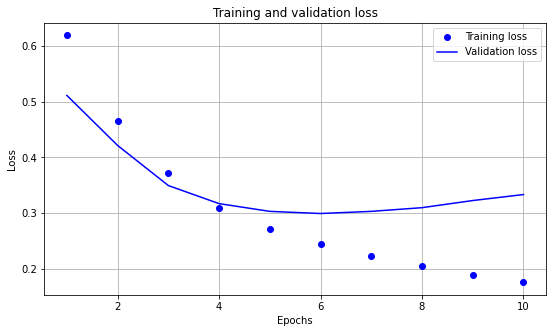

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

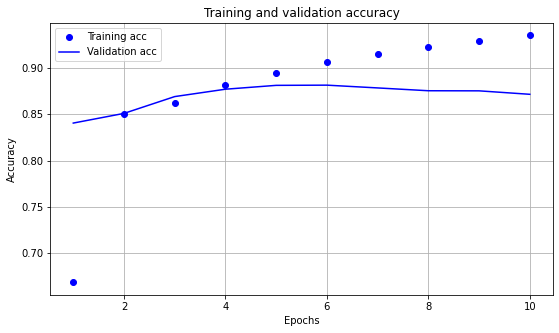

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Just 'meh" for our gaming group.  New version put a lot of bells and whistles on the original Brass but it's still the same, somewhat dry, build your own machine with virtually no interaction between players game.  There's just no room for 'dull/drab' on my shelves these days."
score: 0.000000
actual: 0

input:
"The game is a masterpiece. Pity I can't get it on to the table as much anymore. Would love to give it a 10, but play times, set up, and teardown takes just too much commitment and I find myself grabbing Aeons end or spirit island instead."
score: 1.000000
actual: 1

input:
"1-5 115 minutes Best with 4"
score: 1.000000
actual: 1

input:
"This is so cool. Really simple rules, but nice and thematic mechanics. Starts easy, gets a bit more complex through the game, and end just at the right moment! Normally i am not really a scifi guy for games, but this is really a fun game. I did not know i would like like the looks of this game so much just bases on what you see, but it i

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"Borrowed. Not in our collection "
score: 1.000000

input:
"Scythe Collector's Edition (Kickstarter)"
score: 1.000000

input:
"1-4 Players Worker placemement Engine/Tableau building"
score: 1.000000

input:
"BrokenToken Game Organizer -   BrokenToken Birdhouse Dicetower -   --  Meeple Source Winspan Upgrade Kit (105 pcs) -   Meeple Source 81-piece set of Deluxe North American Wingspan Birds -   Meeple Source 81-piece set of Deluxe European Wingspan Birds -   --  All cards sleeved - Arcane Tinmen Non-Glare  -- "
score: 1.000000

input:
"Rules questions that have come up recently:  The STARTING ADVENTURE CARDS are actually in the market deck, and they do not say "starting" on the back like it says in the rule book. ANY player may use adventure cards at any time, even on another player's turn (as long as they pay the command cost, and there is not already command on the card). TIDES OF RUIN SETUP: Add all of the appropriate cards to their same type in the base game (keep t

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000245A1B96760>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.56


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.01


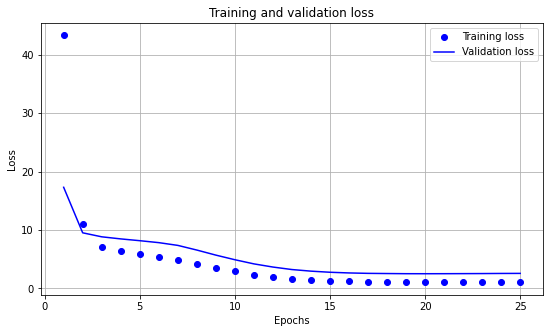

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

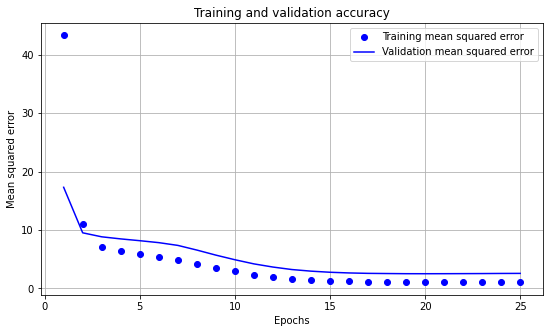

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Just 'meh" for our gaming group.  New version put a lot of bells and whistles on the original Brass but it's still the same, somewhat dry, build your own machine with virtually no interaction between players game.  There's just no room for 'dull/drab' on my shelves these days."
score: 6.23
actual: 5.50 

input: 
"The game is a masterpiece. Pity I can't get it on to the table as much anymore. Would love to give it a 10, but play times, set up, and teardown takes just too much commitment and I find myself grabbing Aeons end or spirit island instead."
score: 8.29
actual: 9.00 

input: 
"1-5 115 minutes Best with 4"
score: 8.98
actual: 9.00 

input: 
"This is so cool. Really simple rules, but nice and thematic mechanics. Starts easy, gets a bit more complex through the game, and end just at the right moment! Normally i am not really a scifi guy for games, but this is really a fun game. I did not know i would like like the looks of this game so much just bases on what you see, but 

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Received November 2019 Turmoil: $139, Shipping: $150"
    reg score: 8.20
    clf score: 1

"Putování po Středozemi je kooperativní desková hra plná dobrodružství a fantazie pro jednoho až pět hráčů. Spolu s přáteli se vžijete do rolí hrdinných postav z J. R. R. Tolkienova Pána prstenů, budete putovat po Středozemi, čelit mocným protivníkům, činit odvážná rozhodnutí a bojovat proti zlu, které ohrožuje celou zemi.  "
    reg score: 8.71
    clf score: 1

"Wird wahrscheinlich verkauft"
    reg score: 0.60
    clf score: 0

"Obtained in a multi-game trade with BoardGameCo.  Really like the initiative system.  The combat system is okay.  Not sure about the leveling up yet."
    reg score: 8.94
    clf score: 1

"8.20.18 - (1 play, 3p) Games that look this good are hard to resist sitting down to play. I’m not a huge worker placement fan, but this wasn’t too bad. Would play again."
    reg score: 5.69
    clf score: 0

"Not my piece of cake. The card mechanism is great, but the very low spe

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.73 |           1920 |
| 162886 |          8.36 |           3590 |
| 167355 |          8.41 |           1893 |
| 167791 |          8.21 |           8371 |
| 169427 |          8.67 |            260 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.27 |            270 |
| 162886 |          8.18 |            319 |
| 167355 |          8.25 |            212 |
| 167791 |          8.23 |            442 |
| 169427 |          8.46 |             74 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/bwABghR...","<a href=""https://boardgamegeek.com/boardgame/3...",9.666667,8.861469,9.264068,1,2021
1,"<img src=""https://cf.geekdo-images.com/fW43z5X...","<a href=""https://boardgamegeek.com/boardgame/3...",6.233766,7.795387,6.661002,2,2021
2,"<img src=""https://cf.geekdo-images.com/U4aoXbK...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,8.183192,NaN,3,2021
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.778272,7.755228,7.776524,4,2020
4,"<img src=""https://cf.geekdo-images.com/cs7Oby2...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,6.122986,NaN,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.666667,8.861469,9.264068,1,2021
2,,Terraforming Mars: Ares Expedition,6.233766,7.795387,6.661002,2,2021
3,,Lost Ruins of Arnak: Expedition Leaders,NaN,8.183192,NaN,3,2021
4,,Lost Ruins of Arnak,7.778272,7.755228,7.776524,4,2020
5,,Free Ride,NaN,6.122986,NaN,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.666667,8.861469,9.264068,1,2021
2,,6: Siege – The Board Game,9.000000,7.970147,8.588059,35,2022
3,,Imperium: Legends,8.800000,7.685668,8.668902,41,2021
4,,War of the Ring: Second Edition,8.729755,8.270898,8.673184,46,2012
5,,Eclipse: Second Dawn for the Galaxy,8.720186,8.046643,8.619400,49,2020


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.666667,8.861469,9.264068,1,2021
2,,War of the Ring: Second Edition,8.729755,8.270898,8.673184,46,2012
3,,Imperium: Legends,8.800000,7.685668,8.668902,41,2021
4,,Brass: Birmingham,8.668901,8.248902,8.631258,22,2018
5,,Middara: Unintentional Malum – Act 1,8.666078,8.459521,8.620314,42,2019


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Way too long for what's in the game. Probably could do an accelerated start without really changing the game besides cutting an hour off of the playtime."
score: 3.17

"Not sure, thinking that I'd be better off waiting for another kickstarter, and after seeing how the game wears over time. Pretty production!"
score: 5.25

"Like new condition, some of the small plastic bags are slightly ripped but still hold pieces. Many extra plastic bags as well."
score: 5.97

"Seems to be very popular but does not appeal to me at all. I guess that mainly I am not that keen on cooperative games."
score: 6.17

"Definitely pretty. Very boring though. Lacked something to grab hold me and my various play groups. 0/6 enjoyed this. (Played x5)"
score: 6.19

"Nice components and mechanisms resource management, upgrades, variability, but at the end of the game not fun for me and I don't enjoy playing it."
score: 6.75

"Needs Sleeves + custom insert. With Shape Squad 3D printed Bird Houses and Food pack (misp

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test